In [1]:
#
# # Ensure we have the needed libraries installed
# 
# %pip install --quiet requests
# %pip install --quiet beautifulsoup4
# %pip install --quiet nbformat

In [2]:
#
# # Access the ETL function 'library'
# 
%run ETL_func_defs.ipynb

****************************** ETL functions def file version v0.0.4 ******************************



In [3]:
#
# # Core user-defined variables
# 

# Might increase potential for cross-client re-use and (some)page changes
urlBase = "https://www.o2.co.uk"
urlSub = "/shop/phones#sort=content.sorting.featured&page=" # page=1+ added later

# client_colour = '#000068' # could used to identify in reporting (this one for O2)

# Define selectors for the scrape 
main_content_selector = ".device-tile-wrapper" # .device-info-content
brand_selector = '[data-qa-device-title] [data-qa-device-brand]'
model_family_selector = '[data-qa-device-title] [data-qa-device-modelfamily]'
star_rating_selector = ".star-rating__stars"
rating_value_selector = ".device-rating__text [itemprop='ratingValue']"
upfront_price_selector = '.upfront-cost-details .headline'
upfront_pence_selector = '.upfront-cost-details .pence'
monthly_price_selector = '.monthly-cost-details .costVal'
monthly_pence_selector = '.monthly-cost-details .costPence'

num_pages = 3 # depth


In [4]:
#
# # IS the site up? No point running anything further it not. 
#
response_time = check_site_status(urlBase, max_response_time=4)
if response_time:
    print('{} is up and available (response time: {:.2f} seconds)'.format(urlBase, response_time))
    
    # run it again for the page(site could be up but page missing? )
    response_time = check_site_status(urlBase+urlSub)
    print('{} is up and available (response time: {:.2f} seconds)'.format(urlBase+urlSub, response_time))
else:
    # Stop any further code below processing
    sys.exit()

https://www.o2.co.uk is up and available (response time: 0.14 seconds)
https://www.o2.co.uk/shop/phones#sort=content.sorting.featured&page= is up and available (response time: 0.04 seconds)


In [5]:
#
# # Extract the page data
#

phone_details_list = extract_phone_details(
    urlBase+urlSub,
    main_content_selector,
    brand_selector,
    model_family_selector,
    star_rating_selector,
    rating_value_selector,
    num_pages,
    upfront_price_selector,
    upfront_pence_selector,
    monthly_price_selector,
    monthly_pence_selector
)



# Visual checks/ref
# Print the extracted phone data details
x = 5  # Just to keep the output cleaner in notebook
for phone_details in itertools.islice(phone_details_list, x):
    print(phone_details)

{'Brand': 'Samsung', 'Model Family': 'Galaxy S23 Ultra', 'Star Rating': None, 'Rating Value': '4.4286', 'Upfront Price': '£30.00*', 'Upfront Pence': '.00*', 'Monthly Price': '£51', 'Monthly Pence': '.87*'}
{'Brand': 'Samsung', 'Model Family': 'Galaxy S23', 'Star Rating': None, 'Rating Value': '5', 'Upfront Price': '£30.00*', 'Upfront Pence': '.00*', 'Monthly Price': '£40', 'Monthly Pence': '.75*'}
{'Brand': 'Samsung', 'Model Family': 'Galaxy S23 Plus', 'Star Rating': None, 'Rating Value': '5', 'Upfront Price': '£30.00*', 'Upfront Pence': '.00*', 'Monthly Price': '£46', 'Monthly Pence': '.31*'}
{'Brand': 'Apple', 'Model Family': 'iPhone 14', 'Star Rating': None, 'Rating Value': '4.3663', 'Upfront Price': '£30.00*', 'Upfront Pence': '.00*', 'Monthly Price': '£37', 'Monthly Pence': '.74*'}
{'Brand': 'Apple', 'Model Family': 'iPhone 14 Pro', 'Star Rating': None, 'Rating Value': '4.5929', 'Upfront Price': '£30.00*', 'Upfront Pence': '.00*', 'Monthly Price': '£47', 'Monthly Pence': '.99*'}


In [6]:
#
# # (1)Pipeline reporting - Identify outliers
#

# Is there anything that we don't expect/want to see in data coming through pipeline?

# Set some (example) default expectations
max_rating_value=5
min_rating_value=2
max_model_family_length=21

outlier_phone_details = identify_outliers(  phone_details_list, 
                                            max_rating_value, 
                                            min_rating_value, 
                                            max_model_family_length 
                                            )


# Are the prices within a logical range(sample/example values selected)
pound_val_keys = ['Monthly Price', 'Upfront Price' ]
pence_val_keys = ['Monthly Pence','Upfront Pence']

outlier_price_details = identify_price_outliers(phone_details_list, pound_val_keys, pence_val_keys)

# output of outliers handled/shown later

In [7]:
# #
# # # (2)Pipeline reporting - Monitor/optimise process
# #
# import timeit # specific to this, so not in function defs

# avg_time = measure_extract_phone_details_time(
#     urlBase,
#     urlSub,
#     main_content_selector,
#     brand_selector,
#     model_family_selector,
#     star_rating_selector,
#     rating_value_selector,
#     num_pages,
#     upfront_price_selector,
#     upfront_pence_selector,
#     monthly_price_selector,
#     monthly_pence_selector
# )

# print(f'Average execution time: {avg_time:.2f} seconds')

In [8]:
#
# # Cleaning
#

# Visual checks/ref
# Print the extracted phone data details
x = 3  # Just to keep the output cleaner in notebook
for phone_details in itertools.islice(phone_details_list, x):
    print(phone_details)



# check/remove unexpected chars/ obv typos
unwanted_chars = ['%', '?', '%', '$', "'", '#', ';', ',','-', '*']
phone_details_list = remove_dodgy_chars(phone_details_list, unwanted_chars)

# remove lead/trailing spaces (and doubles+)
phone_details_list = clean_spacing_phone_details(phone_details_list)

# flatten phone_details_list strings to enforce consistency
phone_details_list = lowercase_phone_details(phone_details_list)

# (re-)enforce proper/title caps (but also handle hyphens and 's properly)
phone_details_list = capitalise_phone_details(phone_details_list)

# remove dirty vals in currency fields, ensure floats
currency_keys_list = ['Upfront Price','Upfront Pence', 'Monthly Price', 'Monthly Pence']
phone_details_list = clean_pricing(phone_details_list, currency_keys_list)


# Remove dups (has to be done LAST, as above cleaning increases chances of matches)
de_dup_keys_list = ['Brand', 'Model Family']
phone_details_list = remove_duplicates(phone_details_list, de_dup_keys_list)




# Visual checks/ref
# Print the extracted phone data details
x = 3  # Just to keep the output cleaner in notebook
for phone_details in itertools.islice(phone_details_list, x):
    print(phone_details)

{'Brand': 'Samsung', 'Model Family': 'Galaxy S23 Ultra', 'Star Rating': None, 'Rating Value': '4.4286', 'Upfront Price': '£30.00*', 'Upfront Pence': '.00*', 'Monthly Price': '£51', 'Monthly Pence': '.87*'}
{'Brand': 'Samsung', 'Model Family': 'Galaxy S23', 'Star Rating': None, 'Rating Value': '5', 'Upfront Price': '£30.00*', 'Upfront Pence': '.00*', 'Monthly Price': '£40', 'Monthly Pence': '.75*'}
{'Brand': 'Samsung', 'Model Family': 'Galaxy S23 Plus', 'Star Rating': None, 'Rating Value': '5', 'Upfront Price': '£30.00*', 'Upfront Pence': '.00*', 'Monthly Price': '£46', 'Monthly Pence': '.31*'}
{'Brand': 'Samsung', 'Model Family': 'Galaxy S23 Ultra', 'Star Rating': None, 'Rating Value': '4.4286', 'Upfront Price': 30.0, 'Upfront Pence': 0.0, 'Monthly Price': 51.0, 'Monthly Pence': 0.87}
{'Brand': 'Samsung', 'Model Family': 'Galaxy S23', 'Star Rating': None, 'Rating Value': '5', 'Upfront Price': 30.0, 'Upfront Pence': 0.0, 'Monthly Price': 40.0, 'Monthly Pence': 0.75}
{'Brand': 'Samsung',

In [9]:
#
# # Ensure consistency
#

# Set required fields to numeric values & make more customer friendly (rounding/set places)
phone_details_list = convert_to_float(phone_details_list, 'Rating Value', 2)


In [16]:
#
# # Enrichment / manipulation
#

#
# # Combine the cleaned price/pence values into single 'useful' val.
data_to_combine = ['Monthly Price', 'Monthly Pence']
new_total_key = 'Monthly Total Price'
phone_details_list = combine_currency_values(phone_details_list, data_to_combine, new_total_key)


data_to_combine = ['Upfront Price', 'Upfront Pence']
new_total_key = 'Upfront Total Price'
phone_details_list = combine_currency_values(phone_details_list, data_to_combine, new_total_key)


# Visual checks/ref
# Print the extracted phone data details
x = 3  # Just to keep the output cleaner in notebook
for phone_details in itertools.islice(phone_details_list, x):
    print(phone_details)

{'Brand': 'Samsung', 'Model Family': 'Galaxy S23 Ultra', 'Star Rating': None, 'Rating Value': 4.43, 'Upfront Price': 30.0, 'Upfront Pence': 0.0, 'Monthly Price': 51.0, 'Monthly Pence': 0.87, 'Monthly Total Price': 51.0087, 'Upfront Total Price': 30.0}
{'Brand': 'Samsung', 'Model Family': 'Galaxy S23', 'Star Rating': None, 'Rating Value': 5.0, 'Upfront Price': 30.0, 'Upfront Pence': 0.0, 'Monthly Price': 40.0, 'Monthly Pence': 0.75, 'Monthly Total Price': 40.0075, 'Upfront Total Price': 30.0}
{'Brand': 'Samsung', 'Model Family': 'Galaxy S23 Plus', 'Star Rating': None, 'Rating Value': 5.0, 'Upfront Price': 30.0, 'Upfront Pence': 0.0, 'Monthly Price': 46.0, 'Monthly Pence': 0.31, 'Monthly Total Price': 46.0031, 'Upfront Total Price': 30.0}


In [11]:
#
# # (1)Represent extracted data in flat file for onward/persistent ref.
#

# Extracted data
save_data_to_file('phone_details', phone_details_list) # main data dump file


# Extracted outlier data
outliers_combined_list = outlier_phone_details + outlier_price_details
if outliers_combined_list:
    # No point outputting an empty file 
    save_data_to_file('outlier_details', outliers_combined_list) # save potential anomalies separately for review

Exporting data to file on path : ./phone_detailscsv
Exporting data to file on path : ./outlier_detailscsv


In [12]:
#
# # (2)Represent data - Visualise some of caught/potential 'outliers'(hypothetical threshold examples)
#

table_data = tabulate(outliers_combined_list, headers='keys', tablefmt='psql')
if len(table_data)>0:
    print("Potential threshold/unexpected data found:\nMax Rating >{}\nModel Family Description >{}"
                                                                        .format(
                                                                                max_rating_value,
                                                                                max_model_family_length
                                                                                ))
    print(table_data)

Potential threshold/unexpected data found:
Max Rating >5
Model Family Description >21
+----------+--------------------------+---------------+----------------+-----------------+-----------------+-----------------+-----------------+
| Brand    | Model Family             | Star Rating   |   Rating Value | Upfront Price   | Upfront Pence   | Monthly Price   | Monthly Pence   |
|----------+--------------------------+---------------+----------------+-----------------+-----------------+-----------------+-----------------|
| Samsung  | Galaxy S23 Ultra         |               |         4.4286 | £30.00*         | .00*            | £51             | .87*            |
| Samsung  | Galaxy S23               |               |         5      | £30.00*         | .00*            | £40             | .75*            |
| Samsung  | Galaxy S23 Plus          |               |         5      | £30.00*         | .00*            | £46             | .31*            |
| Apple    | iPhone 14                |     

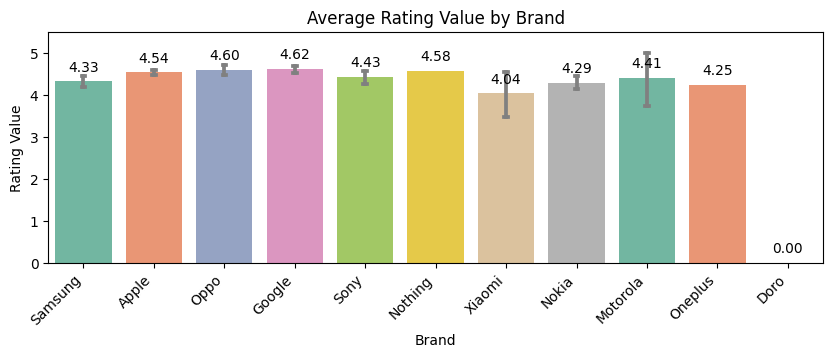

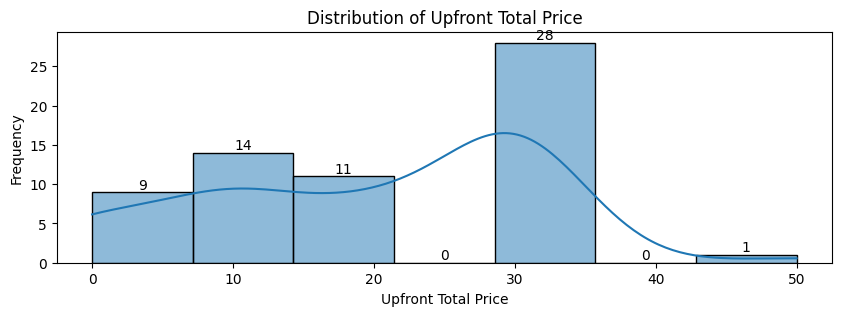

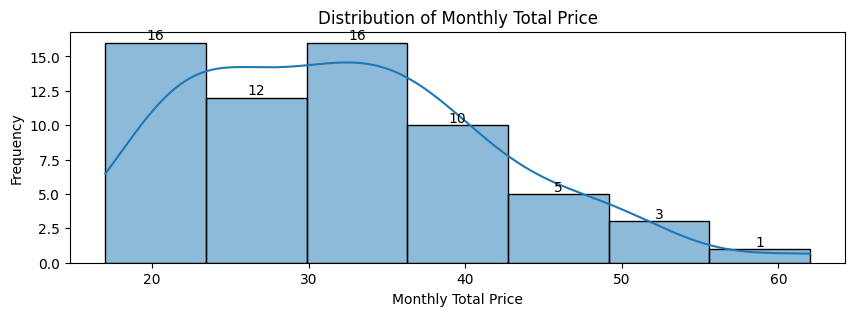

In [13]:
#
# # (3)Represent data - start to consider/show simple stories within the data
#

visualise_average_rating_by_brand(phone_details_list)


visualise_upfront_prices(phone_details_list, 'Upfront Total Price')

visualise_upfront_prices(phone_details_list, 'Monthly Total Price')

In [15]:
#
# # Hypothetical db store + extract (here done only in memory as db not portable)
#

# Create a database connection
conn = sqlite3.connect(":memory:")

# Call the create_phone_details_table() function to create the phone_details table
create_phone_details_table(conn)

# Call the insert_phone_details() function to insert the extracted phone details into the phone_details table
insert_phone_details(conn, phone_details_list)



# Execute a SELECT query on the phone_details table
c = conn.cursor()
c.execute("SELECT brand, model_family, rating_value, upfront_total_price, monthly_total_price FROM phone_details LIMIT 5")

# Fetch the results of the query and print them out
results = c.fetchall()
for row in results:
    print(row)

# Close the database connection
conn.close()

('Samsung', 'Galaxy S23 Ultra', '4.43', 30.0, 51.0087)
('Samsung', 'Galaxy S23', '5.0', 30.0, 40.0075)
('Samsung', 'Galaxy S23 Plus', '5.0', 30.0, 46.0031)
('Apple', 'Iphone 14', '4.37', 30.0, 37.0074)
('Apple', 'Iphone 14 Pro', '4.59', 30.0, 47.0099)
